In [1]:
import scipy
import scipy.optimize as scopt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

%config InlineBackend.figure_format = 'retina'

style.use("classic")

%matplotlib inline

from NRTL import NRTL
from PureComponentData import purecomponentdata

In [2]:
actl = purecomponentdata.Compound("Acetonitrile")
ipa = purecomponentdata.Compound('2-Propanol')
dict_compounds = {"actl":actl, "ipa":ipa}

In [3]:
nrtl = NRTL.NRTL(["actl","ipa"])

In [4]:
nrtl.populate_matrix('A', {'actl-ipa': [1.06994155, 0.03040604]})
nrtl.populate_matrix('alpha',{'actl-ipa': [0.3, 0.3]})

In [5]:
nrtl.yield_parameters()

{'A': {'actl-ipa': [1.06994155, 0.03040604]},
 'B': {'actl-ipa': [0.0, 0.0]},
 'C': {'actl-ipa': [0.0, 0.0]},
 'D': {'actl-ipa': [0.0, 0.0]},
 'alpha': {'actl-ipa': [0.3, 0.3]}}

In [6]:
nrtl.dict_component_index

{'actl': 0, 'ipa': 1}

## Getting Bubble Point and Dew Point

## Bubble Point
We now need to determine the temperature at which the first bubble appears
$$
        P_{Total} = \sum_{i=1}^{N} \gamma_i x_i P_i^{sat}(T)
$$

In [7]:
def get_residual_bubblepoint(T, dict_molfractions, nrtl, Ptotal):
    dict_gammas = nrtl.get_gammas(T, dict_molfractions)
    P = 0.0
    for name in dict_molfractions:
        P += dict_gammas[name]*dict_molfractions[name]*dict_compounds[name].Pvap(T)
    return Ptotal - P

def get_bubble_point(Ptotal, dict_molfractions):    
    Tbubble = scopt.newton(get_residual_bubblepoint, 300.0, args = (dict_molfractions, nrtl, Ptotal))
    return Tbubble


    

In [8]:
dict_molfractions = {"actl":1-0.682, "ipa":0.682}
Ptotal = 1.013e5 #Pa
get_bubble_point(Ptotal, dict_molfractions)-273.16

76.41690862279415

## Dew Point
We now need to determine the temperature at which the final drop disappears.  We have
$$
            P_{Total}y_i = \gamma_i x_i P_i^{sat}(T)
$$
We have to solve:
$$
            \sum_{i=1}^N \frac{P_{Total}y_i}{\gamma_i P_i^{sat}(T)} = 1
$$


In [9]:
def get_residual_dewpoint(T, dict_molfractionsV, dict_molfractionsL, nrtl, Ptotal):
    gammas = nrtl.get_gammas(T, dict_molfractionsL)
    summ = 0.0
    for name in dict_molfractionsL:
        s = Ptotal * dict_molfractionsV[name] / gammas[name] / dict_compounds[name].Pvap(T)
        summ += s
    return summ - 1

def get_dew_point(Ptotal, dict_molfractions):
    bool_go = True
    dict_molfractionsL = dict_molfractions.copy()
    dict_molfractionsV = dict_molfractions.copy()
    Told = 200.0
    while bool_go:
        T = scopt.newton(get_residual_dewpoint, Told, args=(dict_molfractionsV, dict_molfractionsL, nrtl, Ptotal))
        gammas = nrtl.get_gammas(T, dict_molfractionsL)
        sumx = 0.0
        for name in dict_molfractionsV:
            x = Ptotal * dict_molfractionsV[name] / gammas[name] / dict_compounds[name].Pvap(T)
            dict_molfractionsL[name] = x
            sumx += x
        for name in dict_molfractionsL:
            dict_molfractionsL[name] /= sumx
        
        if abs(T - Told) < 0.1:
            bool_go = False
        else:
            Told = T + 0.0
        #print(T)
    return T
        

In [10]:
dict_molfractions = {"actl":1-0.682, "ipa":0.682}
Ptotal = 1.013e5 #Pa
get_dew_point(Ptotal, dict_molfractions)-273.16

77.77460788879233

# Plotting T-x-y diagram
  

In [11]:
x = np.linspace(0,1, 50)
Tdew = np.zeros(len(x))
Tbub = np.zeros(len(x))


Ptotal = 1.013e5 #Pa
for i in range(len(x)):
    dict_molfractions = {"actl":x[i], "ipa":1-x[i]}
    
    Tbub[i] =  get_bubble_point(Ptotal, dict_molfractions)-273.16
    Tdew[i] =  get_dew_point(Ptotal, dict_molfractions)-273.16
    
    


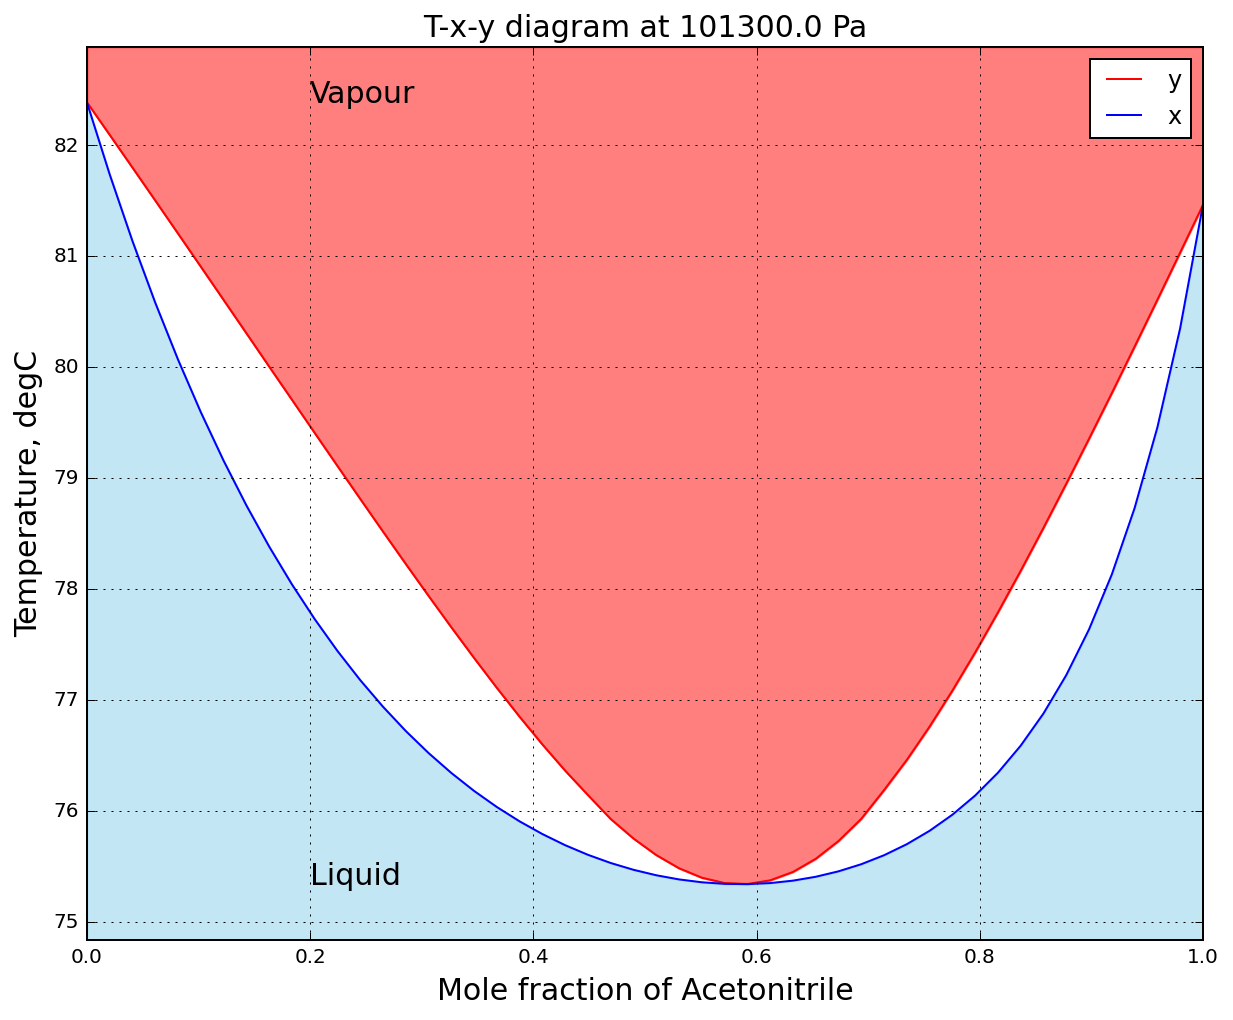

In [12]:
plt.figure(figsize=(10,8)) 
plt.plot(x, Tdew, 'r', label = 'y');
plt.plot(x, Tbub, 'b' , label = 'x');
plt.fill_between(x, Tdew, Tdew[0]+0.5, 
                color = 'red', alpha = 0.5)
plt.fill_between(x, Tbub, np.min(Tbub)-0.5, 
                color = 'skyblue', alpha = 0.5)
plt.xlabel('Mole fraction of Acetonitrile', fontsize = 15)
plt.ylabel('Temperature, degC', fontsize = 15)
plt.xlim([0,1]); plt.ylim([np.min(Tbub)-0.5, Tdew[0]+0.5]);
plt.annotate('Vapour', xy = (0.2,Tdew[0] ), fontsize = 15) ; plt.annotate('Liquid', xy = (0.2,np.min(Tbub) ), fontsize = 15); 
plt.grid();
plt.legend();
plt.title("T-x-y diagram at " + str(Ptotal)+ " Pa", fontsize = 15);

In [13]:
Py = np.zeros(len(x))
Px = np.zeros(len(x))

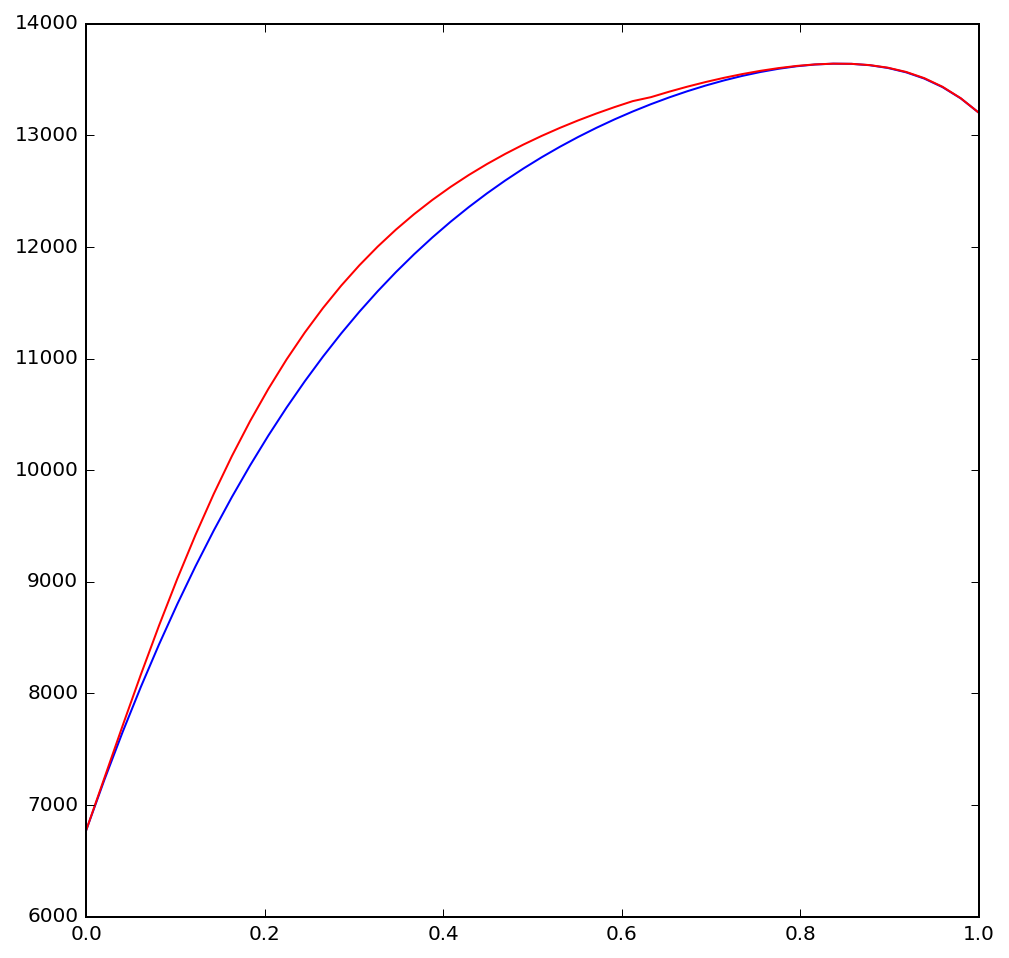

In [14]:
T_con = 300 #K
for i in range(len(x)):
    dict_molfractions = {"actl":x[i], "ipa":1-x[i]}
    dict_gammas = nrtl.get_gammas(T_con, dict_molfractions)
    for name in dict_molfractions:
        Px[i] += dict_gammas[name]*dict_molfractions[name]*dict_compounds[name].Pvap(T_con)
        
    y = dict_gammas["actl"]*dict_molfractions["actl"]*dict_compounds["actl"].Pvap(T_con)/Px[i]
    dict_molfractionsV = {"actl":y, "ipa":1-y}
    Tdew =  get_dew_point(Px[i], dict_molfractionsV)
    dict_gammas_dew = nrtl.get_gammas(Tdew, dict_molfractionsV)
    Pinv = 0 
    for name in dict_molfractionsV:
        Pinv += dict_molfractionsV[name]/(dict_gammas_dew[name]*dict_compounds[name].Pvap(Tdew))
    Py[i] = 1/Pinv
    
plt.figure(figsize=(8,8))        
plt.plot(x, Px, 'b');
plt.plot(x, Py, 'r');    

In [15]:
def get_residual_dewP(P, dict_molfractionsV, dict_molfractionsL, nrtl, T):
    gammas = nrtl.get_gammas(T, dict_molfractionsL)
    summ = 0.0
    for name in dict_molfractionsL:
        s = P * dict_molfractionsV[name] / gammas[name] / dict_compounds[name].Pvap(T)
        summ += s
    return summ - 1

def get_dew_P(T, dict_molfractions):
    bool_go = True
    dict_molfractionsL = dict_molfractions.copy()
    dict_molfractionsV = dict_molfractions.copy()
    Pold = 101325
    while bool_go:
        P = scopt.newton(get_residual_dewP, Pold, args=(dict_molfractionsV, dict_molfractionsL, nrtl, T))
        gammas = nrtl.get_gammas(T, dict_molfractionsL)
        sumx = 0.0
        for name in dict_molfractionsV:
            x = P * dict_molfractionsV[name] / gammas[name] / dict_compounds[name].Pvap(T)
            dict_molfractionsL[name] = x
            sumx += x
        for name in dict_molfractionsL:
            dict_molfractionsL[name] /= sumx
        
        if abs(P - Pold) < 0.1:
            bool_go = False
        else:
            Pold = P + 0.0
        #print(T)
    return P

In [16]:
for i in range(len(x)):
    dict_molfractions = {"actl":x[i], "ipa":1-x[i]}
    
    Py[i] =  get_dew_P(T_con, dict_molfractions)
      

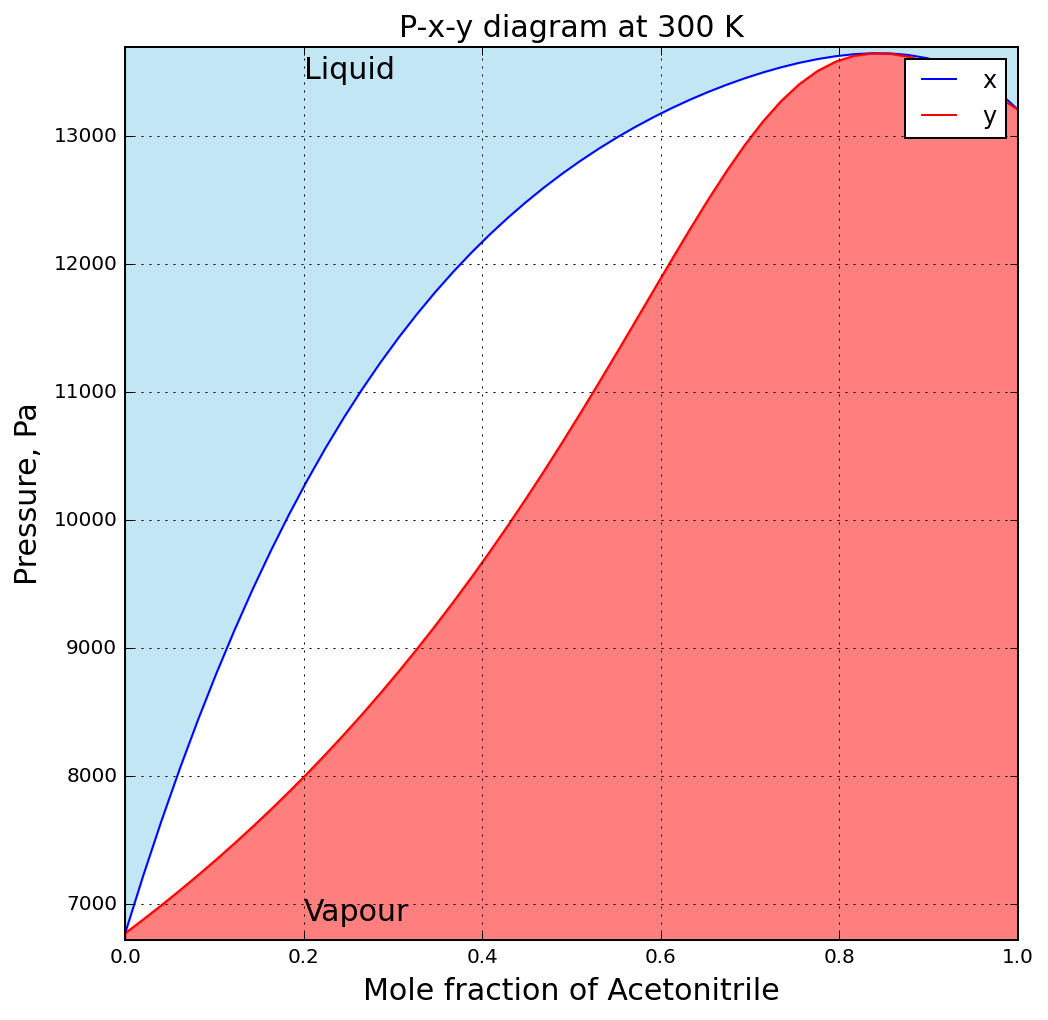

In [17]:
plt.figure(figsize=(8,8))    
plt.plot(x, Px, 'b', label = 'x');
plt.plot(x, Py, 'r', label = 'y');
plt.fill_between(x, Px, np.max(Px)+100,
                 color = 'skyblue', alpha = 0.5)
plt.fill_between(x, Py, np.min(Py)-100, 
                color = 'red', alpha = 0.5)
plt.xlabel('Mole fraction of Acetonitrile', fontsize = 15)
plt.ylabel('Pressure, Pa', fontsize = 15)
plt.xlim([0,1]); plt.ylim([np.min(Py)-50, np.max(Px)+50]);
plt.annotate('Vapour', xy = (0.2,np.min(Py)+100 ), fontsize = 15) ; plt.annotate('Liquid', xy = (0.2,np.max(Px)-200), fontsize = 15); 
plt.grid();
plt.legend();
plt.title("P-x-y diagram at " + str(T_con)+ " K", fontsize = 15);

## Effect of Pressure on Dew Point and Bubble point

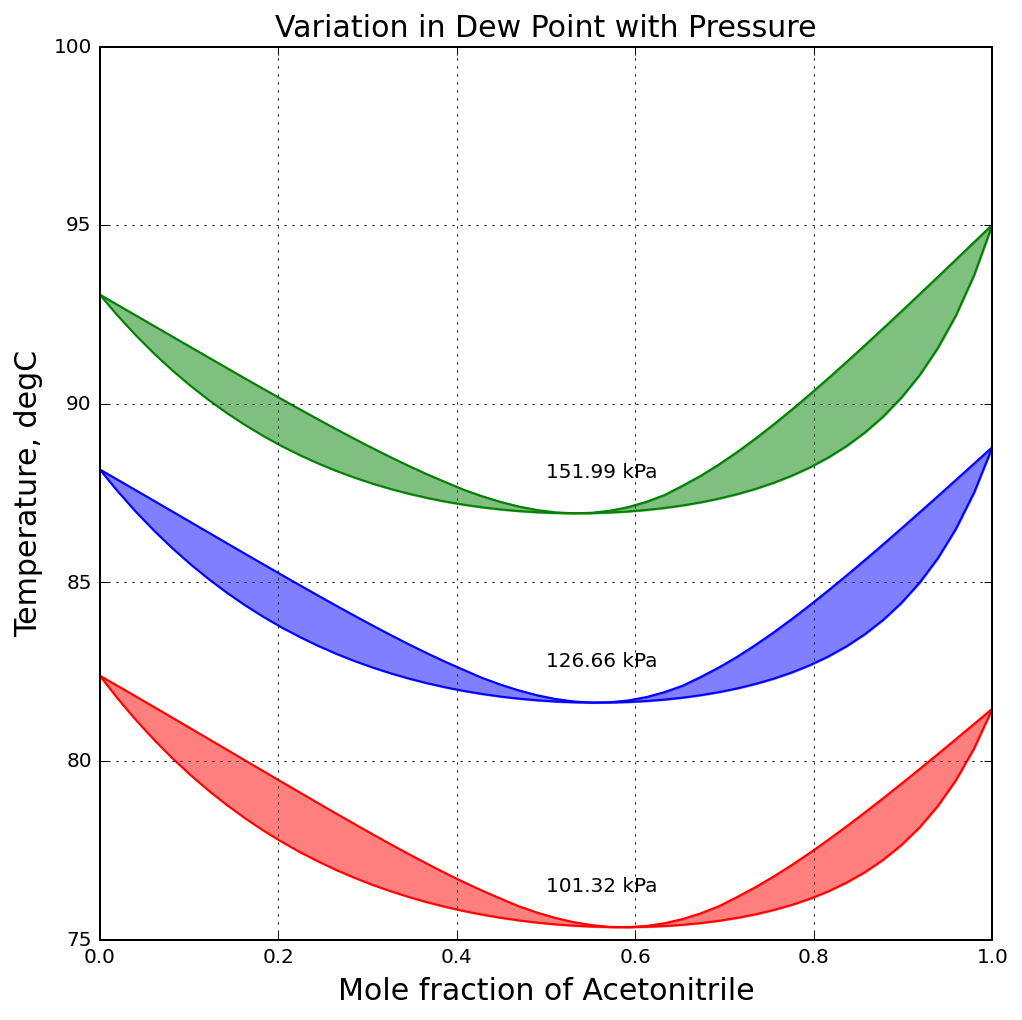

In [18]:
Ptot = np.linspace(101325, 101325*1.5, 3)
x = np.linspace(0,1, 50)
Tdew = np.zeros((len(x), len(Ptot)))
Tbub = np.zeros((len(x), len(Ptot)))
for j in range(len(Ptot)):
    for i in range(len(x)):
        dict_molfractions = {"actl":x[i], "ipa":1-x[i]}
        Ptotal = Ptot[j]    
        Tbub[i][j] =  get_bubble_point(Ptotal, dict_molfractions)-273.16
        Tdew[i][j] =  get_dew_point(Ptotal, dict_molfractions)-273.16
        
col = ['r', 'b', 'g']
plt.figure(figsize = (8,8))
for j in range(len(Ptot)):
    
    plt.plot(x, Tdew[:,j], color = col[j])
    plt.plot(x, Tbub[:,j], color = col[j])
    plt.fill_between(x, Tdew[:,j], Tbub[:,j], 
                color = col[j], alpha = 0.5)
    plt.annotate( str(round(Ptot[j]/1000,2))+' kPa', xy = (0.5, np.min(Tdew[:,j])+1))

plt.title('Variation in Dew Point with Pressure', fontsize = 15) ; 
plt.xlabel('Mole fraction of Acetonitrile', fontsize = 15)
plt.ylabel('Temperature, degC', fontsize = 15)
plt.grid();


Text(0.5, 0, 'Pressure, Pa')

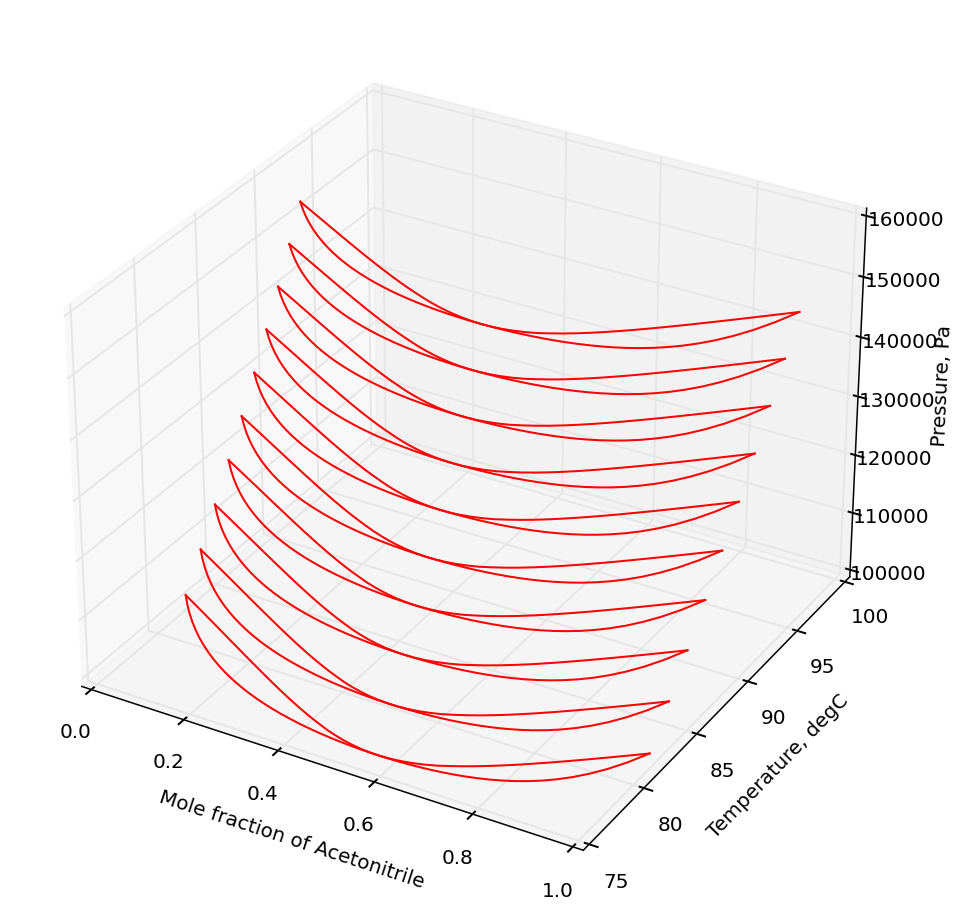

In [19]:
Ptot = np.linspace(101325, 101325*1.5, 10)
x = np.linspace(0,1, 50)
Tdew = np.zeros((len(x), len(Ptot)))
Tbub = np.zeros((len(x), len(Ptot)))
for j in range(len(Ptot)):
    for i in range(len(x)):
        dict_molfractions = {"actl":x[i], "ipa":1-x[i]}
        Ptotal = Ptot[j]    
        Tbub[i][j] =  get_bubble_point(Ptotal, dict_molfractions)-273.16
        Tdew[i][j] =  get_dew_point(Ptotal, dict_molfractions)-273.16
        
#col = ['r', 'b', 'g']
fig = plt.figure(figsize = (8,8))
ax = fig.gca(projection='3d')
for j in range(len(Ptot)):
    
    x,y,z = x, Tdew[:,j], Ptot[j]*np.ones(len(x))
    ax.plot3D(x, y, z,  color = 'r')
    
    x,y,z = x, Tbub[:,j], Ptot[j]*np.ones(len(x))
    ax.plot(x, y, z,  color = 'r')

ax.set_xlabel('Mole fraction of Acetonitrile')
ax.set_ylabel('Temperature, degC')
ax.set_zlabel('Pressure, Pa')


# Homework

# P-T Flash
We are given a stream with known $P_{Total}$, known $T$ and known composition $\{z_i\}$.  We want to know how this stream divides into a vapour and a liquid phase and what its resulting enthalpy is.  Let a fraction $\beta$ of the incoming stream vapourize.  Hence, $F = V + L = \beta F + (1-\beta)F$.  The component mole balance is:
$$
                Fz_i = Vy_i + Lx_i
$$
Equilibrium gives:
$$
                y_i = K_i x_i
$$
Substituting:
$$
                Fz_i = \beta F K_i x_i + (1-\beta) F x_i
$$
i.e. rearranging
$$
                x_i = \frac{z_i}{1 +\beta (K_i-1)}
$$
Hence,
$$
                y_i = K_i x_i = \frac{K_iz_i}{1 +\beta (K_i-1)}
$$
Since $\sum_{i=1}^N (y_i-x_i) = 0$, hence,
$$
              \sum_{i=1}^N\frac{(K_i-1)z_i}{1 +\beta (K_i-1)} = 0 
$$
This is the famous Rachford Rice Equation.

Let us call $S = \sum_{i=1}^N\frac{(K_i-1)z_i}{1 +\beta (K_i-1)}$.  Hence,
$$
    \frac{dS}{d\beta} = -\sum_{i=1}^N\frac{z_i(K_i-1)^2}{(1 +\beta (K_i-1))^2}
$$
This derivative is always negative!  i.e. Newton Raphson is always monotonous.  We are guaranteed a solution of $\beta$.
Once we have a value of $\beta$, we can use it to find $x_i$ from:
$$
                x_i = \frac{z_i}{1 +\beta (K_i-1)}
$$
And we can get our new values of $K_i$.  And the iterations continue until we get no improvement in the value of $\beta$.
Note for low pressures and reasonably high temperatures:
$$
                K_i = \gamma_i P_i^{sat}/P_{Total}
$$

In [20]:
def get_K(T, P_total, dict_molfractions):
    gammas = nrtl.get_gammas(T, dict_molfractions)
    K = {}
    for name in gammas:
        K[name] = dict_compounds[name].Pvap(T)*gammas[name] / P_total
    return K
    
def residual_beta(beta, z, K):
    S = 0
    for name in z:
        S += (K[name] - 1)*z[name]/(1+beta*(K[name]-1))
    return S

def get_beta(z, K, betaguess = 0.5):
    beta = scopt.newton(residual_beta, betaguess, args = (z, K))
    return beta

def get_x(z, K, beta):
    x = {}
    for name in z:
        x[name] = z[name]/(1+beta*(K[name]-1))
    return x
    

In [21]:
def flash_PT(T, Ptotal, dict_molfractions):
    Tbubble = get_bubble_point(Ptotal, dict_molfractions)
    Tdew = get_dew_point(Ptotal, dict_molfractions)

    if T >= Tdew:
        beta = 1 
        x = 'junk'
        y = dict_molfractions.copy()
    elif T <= Tbubble:
        beta = 0
        y = 'junk'
        x = dict_molfractions.copy()
    else:
        betaguess = (T - Tbubble)/(Tdew - Tbubble)
        K = get_K(T, Ptotal, dict_molfractions) #starting guess of K
        bool_go = True
        while bool_go:
            beta = get_beta(dict_molfractions, K, betaguess = betaguess)
            x = get_x(dict_molfractions, K, beta)
            #print(beta, betaguess)
            if abs(beta - betaguess)/beta < 0.001:
                bool_go = False
            else:
                betaguess = beta + 0.0
                K = get_K(T, Ptotal, x) #update of K
        y = {}
        for name in x:
            y[name] = K[name]*x[name]
    return beta,x,y

In [22]:
Ptotal = 1.013e5 #Pa
T = 77.5 + 273.16 #K
F = 1.0 #kmol/s
x1 = 0.2
dict_molfractions = {"ipa":1-x1,  "actl":x1}
flash_PT(T, Ptotal, dict_molfractions)

(0, {'ipa': 0.8, 'actl': 0.2}, 'junk')

## Checking in the dew point and bubble points: 

In [23]:
x = np.linspace(0,1, 50)
Tdew = np.zeros(len(x))
Tbub = np.zeros(len(x))
Tflash = np.zeros(len(x))


Ptotal = 1.013e5 #Pa
for i in range(len(x)):
    dict_molfractions = {"actl":x[i], "ipa":1-x[i]}
    
    Tbub[i] =  get_bubble_point(Ptotal, dict_molfractions)-273.16
    Tdew[i] =  get_dew_point(Ptotal, dict_molfractions)-273.16
    Tflash[i] = (Tdew[i] + Tbub[i])/2 + 273.16

k = 25
dict_molfractions = {"ipa":1-x[k],  "actl":x[k]}
flash_PT(Tflash[k], Ptotal, dict_molfractions)

(0.6784275639827381,
 {'ipa': 0.5244443015445776, 'actl': 0.47555569845542245},
 {'ipa': 0.4733726985958032, 'actl': 0.5266273014041968})

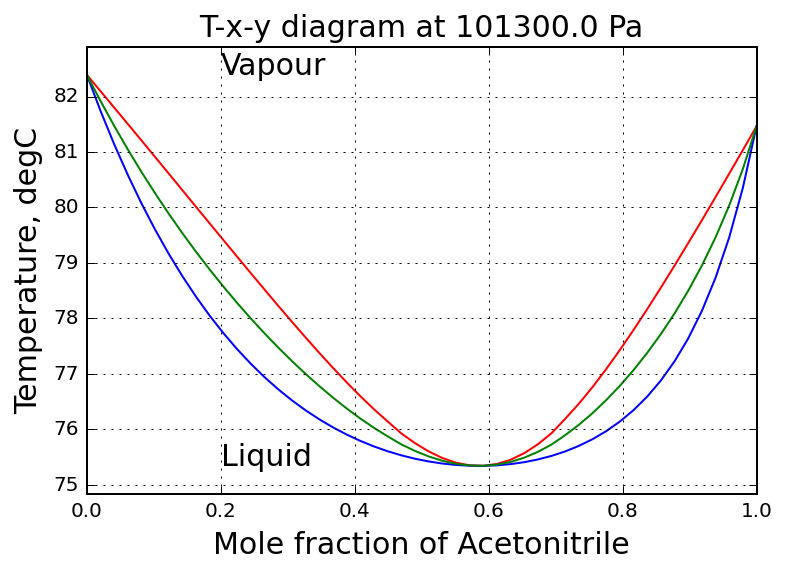

In [24]:
plt.plot(x, Tdew, 'r')
plt.plot(x, Tbub, 'b')
plt.plot(x, Tflash-273.16, 'g')
plt.xlabel('Mole fraction of Acetonitrile', fontsize = 15)
plt.ylabel('Temperature, degC', fontsize = 15)
plt.xlim([0,1]); plt.ylim([np.min(Tbub)-0.5, Tdew[0]+0.5]);
plt.annotate('Vapour', xy = (0.2,Tdew[0] ), fontsize = 15) ; plt.annotate('Liquid', xy = (0.2,np.min(Tbub) ), fontsize = 15); 
plt.grid();
#plt.legend();
plt.title("T-x-y diagram at " + str(Ptotal)+ " Pa", fontsize = 15);
#print(x)

In [25]:
bflash = np.linspace(0,1, 50)
xflash = np.linspace(0,1, 50)
yflash = np.linspace(0,1, 50)


c = 0 
for i in range(len(x)):
    dict_molfractions = {'actl':x[i], 'ipa':1-x[i]}
    
    b,xf,yf = flash_PT(Tflash[i], Ptotal, dict_molfractions)
    if xf=='junk':
        xflash[i] = 0 
    elif yf=='junk':
        yflash[i] = 1
    else:
        
        bflash[i] = b ; xflash[i] = xf['actl'] ; yflash[i] = yf['actl']
    #print(b, xf, yf)
    c+=1



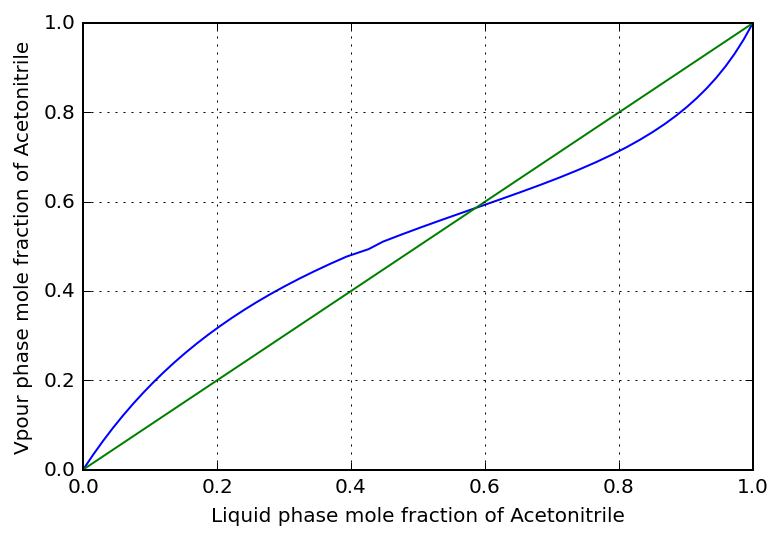

In [26]:
xflash[-1] = 1
plt.plot(xflash ,yflash)
plt.plot([0,1], [0,1])
plt.xlabel("Liquid phase mole fraction of Acetonitrile")
plt.ylabel("Vpour phase mole fraction of Acetonitrile")
plt.grid()

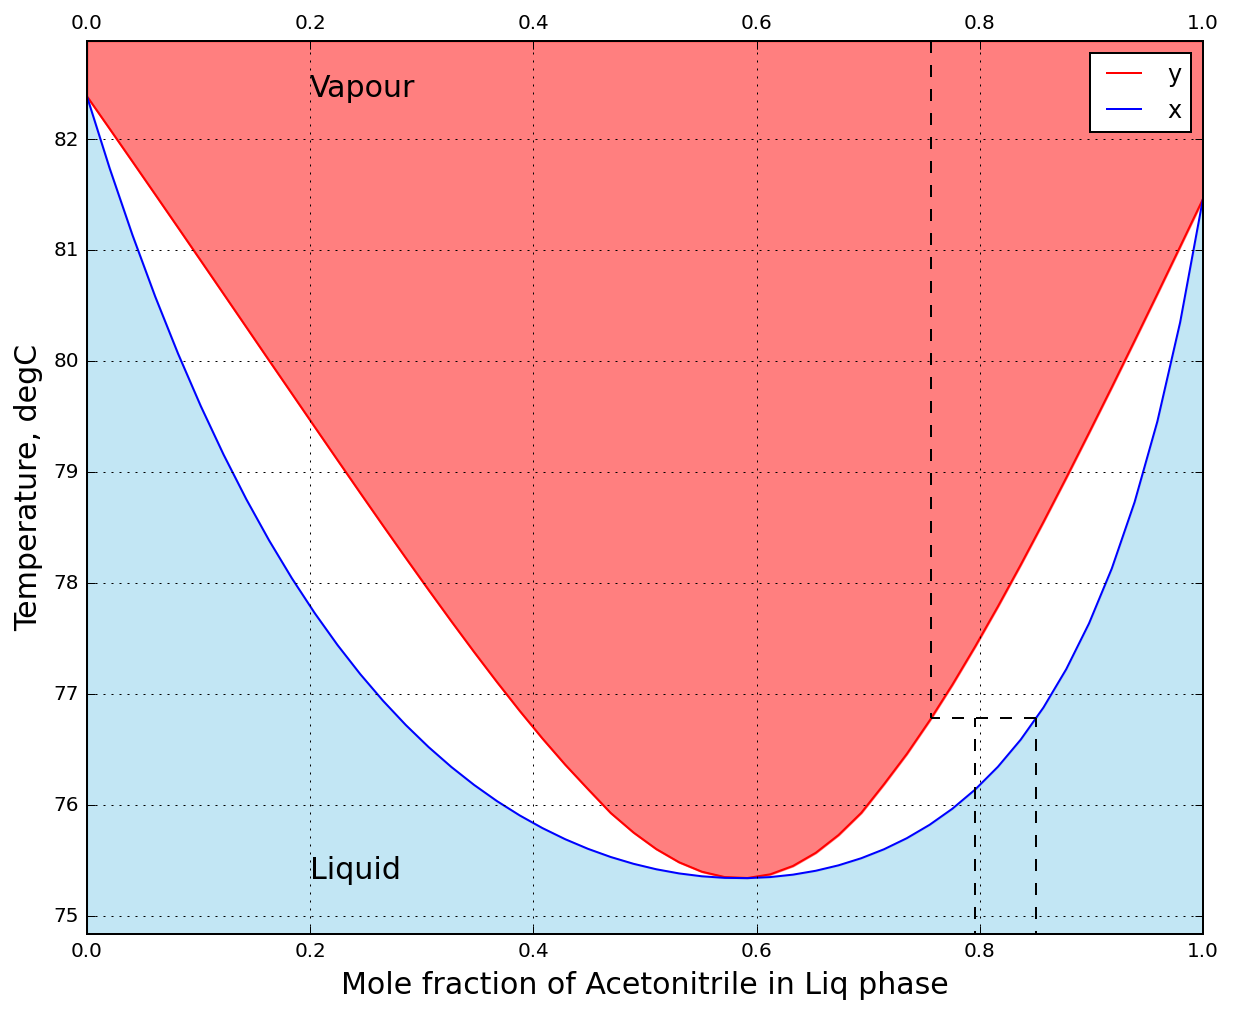

In [27]:
composition = 0.8 
index = int(composition*(len(x)-1))
fig, ax = plt.subplots(figsize = (10,8)) 
ax.plot(x, Tdew, 'r', label = 'y');
ax.plot(x, Tbub, 'b' , label = 'x');
ax.plot([x[index], x[index]], [0, Tflash[index]-273.16], 'k--')
ax.plot([xflash[index], yflash[index]], [Tflash[index]-273.16, Tflash[index]-273.16], 'k--')
ax.plot([xflash[index], xflash[index]], [0, Tflash[index]-273.16], 'k--')

ax.plot([yflash[index], yflash[index]], [Tdew[0]+0.5, Tflash[index]-273.16], 'k--')
ax.fill_between(x, Tdew, Tdew[0]+0.5, 
                color = 'red', alpha = 0.5)
ax.fill_between(x, Tbub, np.min(Tbub)-0.5, 
                color = 'skyblue', alpha = 0.5)
ax.set_xlabel('Mole fraction of Acetonitrile in Liq phase', fontsize = 15)
ax.set_ylabel('Temperature, degC', fontsize = 15)
#ax.set_title("T-x-y diagram at " + str(Ptotal)+ " Pa", fontsize = 15, loc = 'center'); 

#ax.xaxis.set_label_position('top')

def units(x):
    return x
unit = units
secax = ax.secondary_xaxis('top', functions = (units, unit))
#secax.set_xlabel('Mole fraction of Acetonitrile in Vapour phase', fontsize = 10)
ax.set_xlim([0,1]); plt.ylim([np.min(Tbub)-0.5, Tdew[0]+0.5]);
ax.annotate('Vapour', xy = (0.2,Tdew[0] ), fontsize = 15) ; plt.annotate('Liquid', xy = (0.2,np.min(Tbub) ), fontsize = 15); 
ax.grid();
ax.legend();


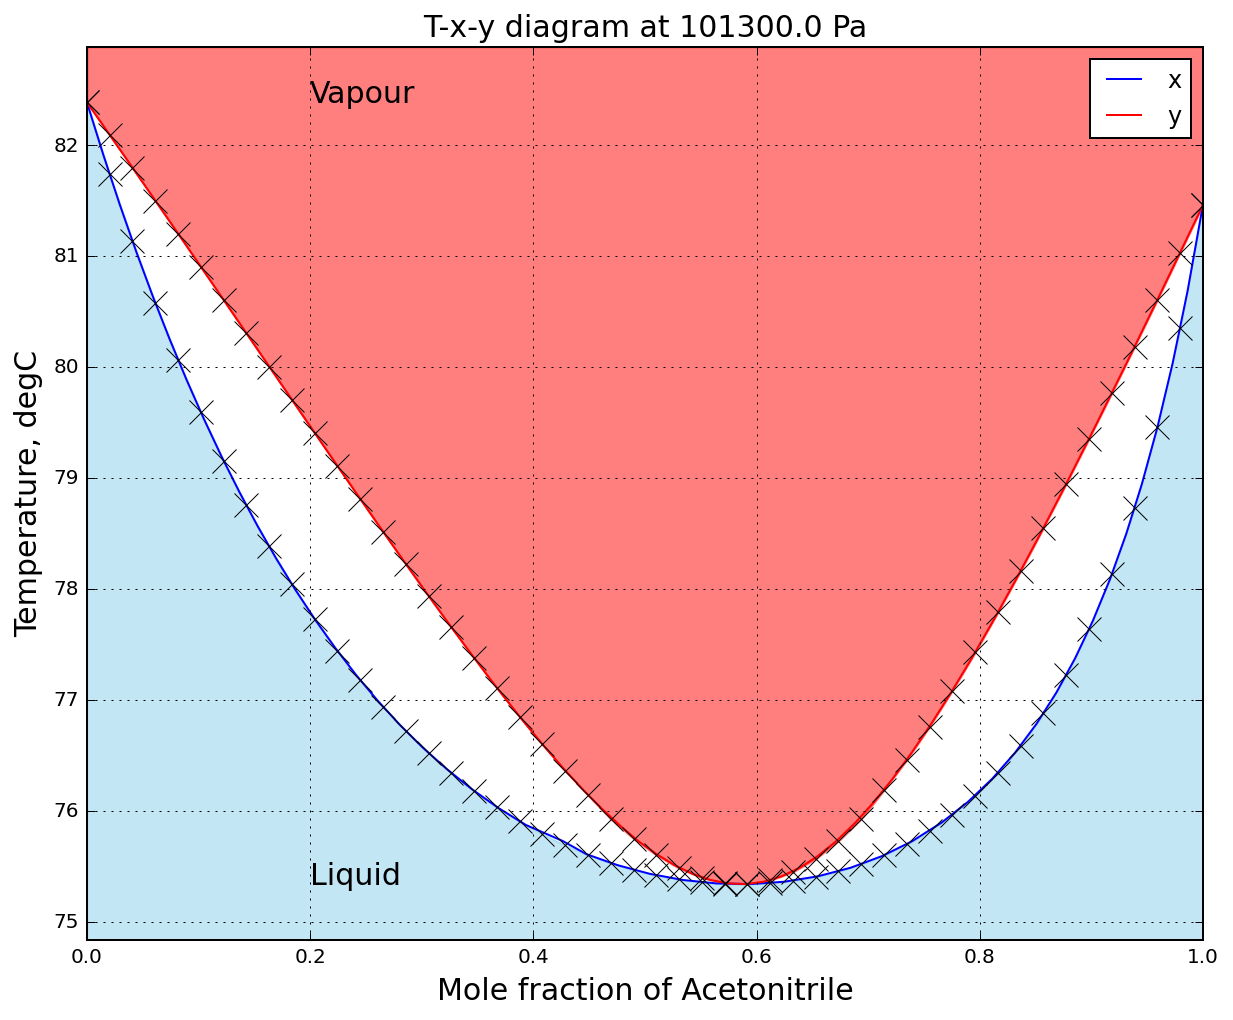

In [28]:
plt.figure(figsize = (10,8))
plt.plot(xflash, Tflash - 273.16, 'b', label = 'x')
plt.plot(yflash, Tflash - 273.16, 'r', label = 'y')
plt.plot(x, Tdew, 'kx', markersize = 12)
plt.plot(x, Tbub, 'kx', markersize = 12)
plt.fill_between(x, Tdew, Tdew[0]+0.5, 
                color = 'red', alpha = 0.5)
plt.fill_between(x, Tbub, np.min(Tbub)-0.5, 
                color = 'skyblue', alpha = 0.5)
plt.xlabel('Mole fraction of Acetonitrile', fontsize = 15)
plt.ylabel('Temperature, degC', fontsize = 15)
plt.xlim([0,1]); plt.ylim([np.min(Tbub)-0.5, Tdew[0]+0.5]);
plt.annotate('Vapour', xy = (0.2,Tdew[0] ), fontsize = 15) ; plt.annotate('Liquid', xy = (0.2,np.min(Tbub) ), fontsize = 15); 
plt.grid();
plt.legend();
plt.title("T-x-y diagram at " + str(Ptotal)+ " Pa", fontsize = 15);

In [29]:
#b,x,y = flash_PT(Tflash, Ptotal, dict_molfractions)
# b is the value of beta
# x is liq phase molfrac stored as dictionary
# y is vap phase molfrac stored as dictionary